# Course 27666 AI-guided Protein Science

# Graph Machine Learning

# Shallow Embeddings Methods
## Node2Vec and DeepWalk with PyTorch Geometric (PyG)



## Install PyG

In [35]:
# Uncomment and run the following commands if PyG is not installed.
#!pip install torch torch-geometric matplotlib torch-cluster scikit-learn

## 1. Helper Functions for Visualization

In [73]:
import pandas as pd
import torch
from torch_geometric.nn import Node2Vec
import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt


def visualize_embeddings(embeddings, labels):
    """
    Visualizes node embeddings using t-SNE.

    Args:
        embeddings (torch.Tensor): Node embeddings of shape [num_nodes, embedding_dim].
        labels (torch.Tensor): Node labels of shape [num_nodes].
    """
    from sklearn.manifold import TSNE

    # Apply t-SNE to reduce dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

    # Scatter plot of embeddings
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="Set1", s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.show()

def create_graph(G):
    """
    Creates a sample NetworkX graph and converts it to a PyTorch Geometric Data object.

    Returns:
        data (torch_geometric.data.Data): The PyG Data object containing the graph.
        labels (torch.Tensor): Ground-truth node labels for visualization.
    """
  
    G = nx.karate_club_graph()

    # Assign labels based on the club membership
    labels = torch.tensor([G.nodes[n]["club"] == "Mr. Hi" for n in G.nodes], dtype=torch.long)

    # Convert to PyG Data object
    data = from_networkx(G)
    data.y = labels  # Add labels to the graph data

    return data, labels

In [ ]:
print("Creating the graph...")
data, labels = create_sample_graph()

## 2. Define Model Parameters

In [60]:
embedding_dim=64 # Determines the size of the learned vector representations (embeddings) for each node in the graph
walk_length=20 # This is a key parameter to control how deep the walks go in the graph.
context_size=10 # Defines how many neighboring nodes (within a given distance from the current node) are used to predict the target node.
walks_per_node=10 # Defines how many random walks are generated per node in the graph.
num_epochs=100 

## 3. Node2Vec Implementation

#### Instantiate the Node2Vec model

In [61]:
# p - # Return parameter controls the likelihood of immediately revisiting the previous node during a random walk. 
# q In-out" parameter controls the likelihood of exploring nodes that are close or far from the current node. 
model = Node2Vec(
    edge_index=data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=0.2,
    q=0.5,
    sparse=True, #This parameter indicates whether to store the embeddings in sparse format or not (True - computationally efficient)
)

### Train the model

In [62]:
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Sample random walks for positive and negative samples using a specific node batch
    batch_size = 32  # Set the batch size for sampling
    num_batches = (data.num_nodes + batch_size - 1) // batch_size  # Calculate the number of batches
    
    # Train on each batch of nodes
    for i in range(num_batches):
        # Get the current batch of nodes
        batch_nodes = torch.arange(i * batch_size, min((i + 1) * batch_size, data.num_nodes))
        
        # Sample random walks for the current batch of nodes
        # pos_rw would contain the positive samples (the node itself and its neighbors)
        #neg_rw contains the negative samples (nodes that are not neighbors, usually sampled randomly)
        pos_rw, neg_rw = model.sample(batch_nodes)  # Pass a batch of nodes for sampling
        
        # Calculate the loss for the current batch
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
    
    # Update model parameters after each batch
    optimizer.step()
    
    # Print the loss at every 10th epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 6.942193984985352
Epoch 10, Loss: 5.5647382736206055
Epoch 20, Loss: 4.2929840087890625
Epoch 30, Loss: 3.0488717555999756
Epoch 40, Loss: 2.8861241340637207
Epoch 50, Loss: 2.5792930126190186
Epoch 60, Loss: 2.5770885944366455
Epoch 70, Loss: 2.2524054050445557
Epoch 80, Loss: 2.141613006591797
Epoch 90, Loss: 2.279317855834961


### Get the embeddings after training

In [64]:
node2vec_embeddings = model.embedding.weight

## 4. Visualising Node2Vec Embeddings


Training Node2Vec...


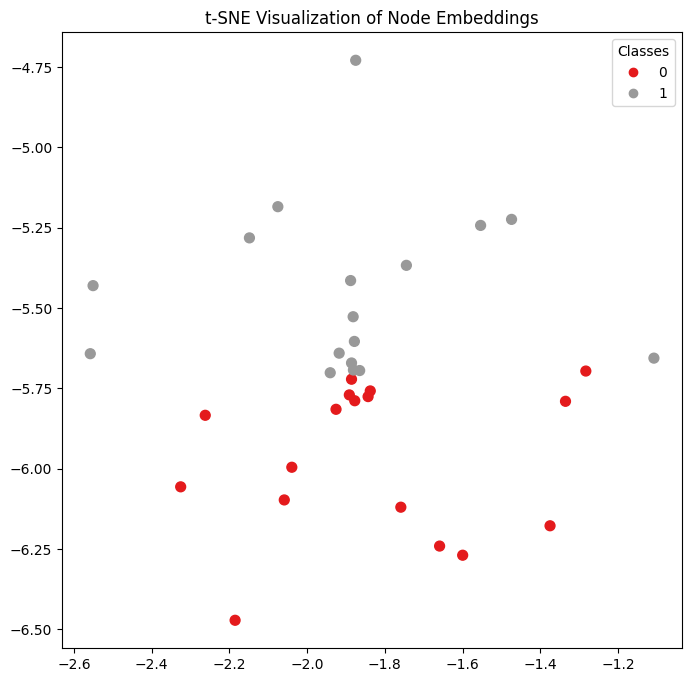

In [65]:
visualize_embeddings(node2vec_embeddings, labels)


## 5. DeepWalk as a Special Case of Node2Vec

### Initialize Node2Vec with p=1 and q=1 (DeepWalk settings)

In [52]:
# p - # Return parameter controls the likelihood of immediately revisiting the previous node during a random walk. 
# A value of 1.0 means there's no bias towards revisiting nodes, making the walk more random.
# q In-out" parameter controls the likelihood of exploring nodes that are close or far from the current node. 
# A value of 1.0 means that there's no bias towards either direction, and the walk is more balanced.
model = Node2Vec(
    edge_index=data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1.0,  # Return parameter
    q=1.0,  # In-out parameter
    sparse=True
)

### Train the model

In [66]:
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Sample random walks for positive and negative samples using a specific node batch
    batch_size = 32  # Set the batch size for sampling
    num_batches = (data.num_nodes + batch_size - 1) // batch_size  # Calculate the number of batches
    
    # Train on each batch of nodes
    for i in range(num_batches):
        # Get the current batch of nodes
        batch_nodes = torch.arange(i * batch_size, min((i + 1) * batch_size, data.num_nodes))
        
        # Sample random walks for the current batch of nodes
        pos_rw, neg_rw = model.sample(batch_nodes)  # Pass a batch of nodes for sampling
        
        # Calculate the loss for the current batch
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
    
    # Update model parameters after each batch
    optimizer.step()
    
    # Print the loss at every 10th epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.217787504196167
Epoch 10, Loss: 1.9960956573486328
Epoch 20, Loss: 1.953965425491333
Epoch 30, Loss: 2.0914649963378906
Epoch 40, Loss: 1.9845225811004639
Epoch 50, Loss: 2.122910737991333
Epoch 60, Loss: 2.0817089080810547
Epoch 70, Loss: 2.1663856506347656
Epoch 80, Loss: 2.1824443340301514
Epoch 90, Loss: 2.147550582885742


### Get the embeddings after training

In [68]:
deepwalk_embeddings = model.embedding.weight  # Corrected line to access learned embeddings

## 4. Running and Visualizing the Models


Visualizing DeepWalk Embeddings...


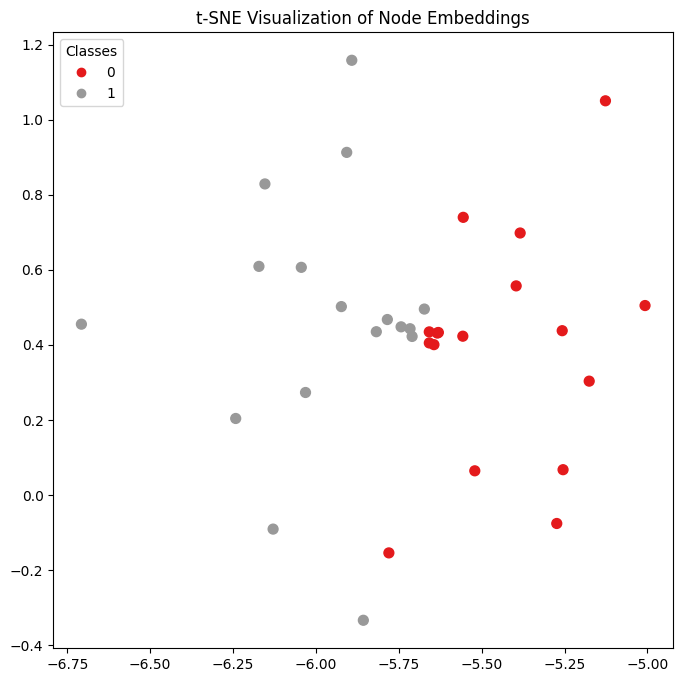

In [69]:
print("\nVisualizing DeepWalk Embeddings...")
visualize_embeddings(deepwalk_embeddings, labels)